In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0, max=L[i])
    return x


In [3]:
N_Agents = 4
in_dim = 1
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 32
control_energy_reg = 1e-5#1e-6 ### regularization on maximum control energy
u_max = 1 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [4]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    # = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    #return np.where((x > 0.6) & (x < 0.9),3, 0)
max_pdf = 5 / 3

In [5]:
from densities import uniform_rect_regions as pdf
import functools
region  = np.array([[[0, 0.3], [0, 0.3]],
                    [[0.6, 0.9], [0.7, 0.9]]])
#custom_pdf = functools.partial(pdf, regions=region)

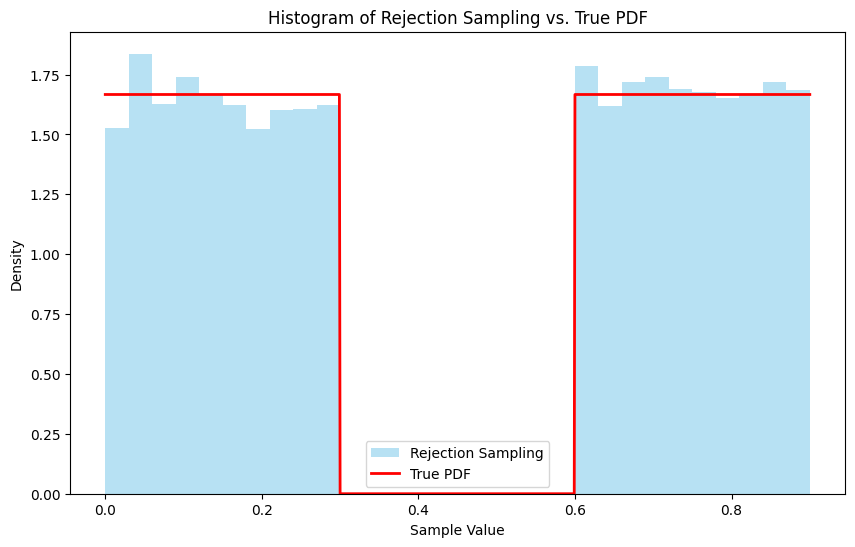

tensor([ 1.0000,  0.1090,  0.3531,  0.4414, -0.4612,  0.0101, -0.0674,  0.0521,
        -0.0308,  0.1604, -0.0150, -0.1483,  0.0014, -0.0384,  0.0375, -0.0091,
         0.1174, -0.0713, -0.0513, -0.0195, -0.0033, -0.0052,  0.0179,  0.0628,
        -0.0863, -0.0125, -0.0206,  0.0052, -0.0172,  0.0508,  0.0062, -0.0559]) target distribution


In [6]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = max_pdf, num_samples = 10000)


In [7]:
############ Empircally we need loss < 0.01
import time
criterion.verbose = True
epochs = 1000  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
decreased = False
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, eps = 1e-4)
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty # punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)    
    avg_loss = running_loss / (n_samples // batch_size)
    ### He gets stuck here and often times not unstuck!
    if avg_loss < 0.011 and not decreased:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        decreased = True
    if avg_loss < 0.009:
        break

    #scheduler.step(avg_loss) #### In our case test loss is the same as train loss
    print() 
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
plt.legend()
plt.show()
print("Training Complete!")

torch.Size([256, 32])
model: tensor(-0.6309, grad_fn=<SelectBackward0>) target: tensor(0.1090)
per iter: 1.4896624088287354 total time: 11917.299270629883

Epoch [1/1000], Loss: 2836.852570, lr: 0.001000

Epoch [2/1000], Loss: 2770.685181, lr: 0.001000

Epoch [3/1000], Loss: 2744.412750, lr: 0.001000

Epoch [4/1000], Loss: 2709.522797, lr: 0.001000


In [ ]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 256, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 256)
outs, control = model(inital_state)
criterion(x = outs, u = control)

torch.Size([256, 32])
model: tensor(0.1417, grad_fn=<SelectBackward0>) target: tensor(0.1383)


tensor(0.0090, grad_fn=<AddBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


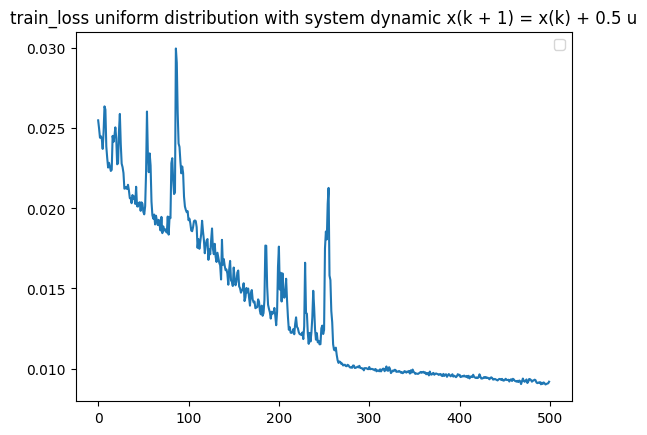

Training Complete!


In [ ]:
plt.plot(train_loss[-500:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

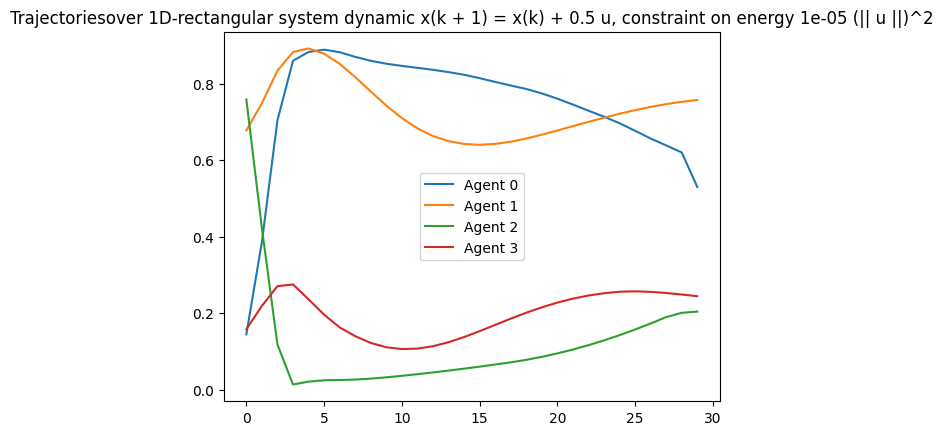

torch.Size([1, 32])
model: tensor(0.1371, grad_fn=<SelectBackward0>) target: tensor(0.1383)


tensor(0.0059, grad_fn=<AddBackward0>)

In [ ]:
#plot trajectory
#model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)



In [ ]:
import uuid
import os
random_id = str(uuid.uuid4())[:8]
filename = f'model_uniform_region_Noise_0-0.3.0.6-0.9_multiple_Agents{random_id}.pth'
path = os.path.join('models' , filename)
torch.save(model.state_dict(), path)
print(f"Model saved with filename: {filename}")

Model saved with filename: model_uniform_region_0-0.3.0.6-0.9_multiple_Agents19da233e.pth


In [ ]:
ev = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32 , depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
ev.load_state_dict(torch.load(path))

<All keys matched successfully>

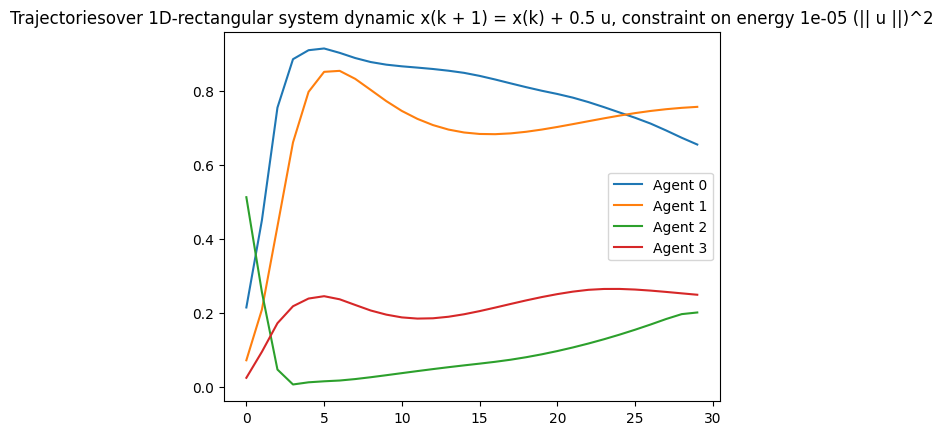

torch.Size([1, 32])
model: tensor(0.1484, grad_fn=<SelectBackward0>) target: tensor(0.1383)


tensor(0.0198, grad_fn=<AddBackward0>)

In [ ]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
ev.init_hidden(batch_size = 1)
outs, control = ev(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)